In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-04-25 05:06:44--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-04-25 05:06:44 (20.7 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("".join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
def encode(text):
  return [stoi[ch] for ch in text]
def decode(nums):
  return ''.join([itos[i] for i in nums])

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import math

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'CPU'
device

'cuda'

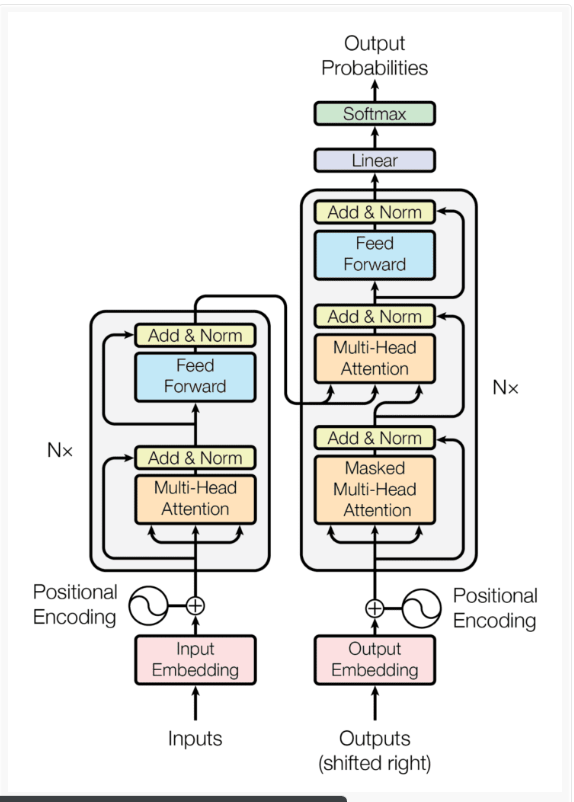

In [ ]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

The matrix multiplication between these two will involve three multiplications between corresponding 2D matrices of A and B having shapes (3,2) and (2,4) respectively. Specifically, the first multiplication will be between A[0] and B[0], the second multiplication will be between A[1] and B[1], and finally, the third multiplication will be between A[2] and B[2]. The result of each individual multiplication of 2D matrices will be of shape (3,4). Hence, the final product of the two 3D matrices will be a matrix of shape (3,3,4).

# positional encoding code

In [ ]:
seq_len = 8
embed = 16
pos_encoding = torch.zeros(seq_len, embed).to(device)

In [ ]:
for pos in range(seq_len):
  for i in range(0,embed,2):
    pos_encoding[pos,i] = math.sin(pos / (10000 ** ((2 * i)/embed)))
    pos_encoding[pos, i+1] = math.cos(pos / (10000 ** ((2 * (i + 1))/embed)))

pos_encoding = pos_encoding.unsqueeze(dim=0)



In [ ]:
pos_encoding[:,:4].shape[1]

4

In [ ]:
# pos.shape

https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch

In [ ]:
embed_size = 512
context_length = 256
batch_size = 64
head_size = 64
num_blocks = 4
num_heads = embed_size//head_size
dropout_prob = 0.2
chars = sorted(list(set(text)))
vocab_size = len(chars)
data = torch.tensor(encode(text), dtype= torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
def get_batch(split):
  data = train_data if split == 'train' else val_data
  # generates 4 random starting indexes from 0 to len(data)-block_size
  ix = torch.randint(len(data)-context_length, (batch_size,))
  # stack all the data of contextual block size 8 on top of one another
  x = torch.stack([data[i:i+context_length] for i in ix])
  y = torch.stack([data[i+1:i+context_length+1] for i in ix])
  # x, y = x.to(device), y.to(device)
  return x,y 
dropout_prob = 0.2
class Embedding(nn.Module):

  def __init__(self, vocab_size, embed_size):
    super().__init__()
    self.token_embeddings = nn.Embedding(vocab_size, embed_size)
  
  def forward(self, input):
    out = self.token_embeddings(input)
    # print(out.shape)
    return out

class PositionalEmbedding(nn.Module):
  """For every token in context length we will generate a positional encoding"""

  def __init__(self, context_len, embed_size):
    super().__init__()
    pos_encoding = torch.zeros(context_len, embed_size)
    for pos in range(context_len):
      for i in range(0,embed_size,2):
        pos_encoding[pos,i] = math.sin(pos / (10000 ** ((2 * i)/embed_size)))
        pos_encoding[pos, i+1] = math.cos(pos / (10000 ** ((2 * (i + 1))/embed_size)))
    pos_encoding = pos_encoding.unsqueeze(dim=0)
    pos_encoding = pos_encoding
    # self.dropout = nn.Dropout(dropout_prob)
    self.register_buffer('pe',pos_encoding)
  
  def forward(self, input):
    context_len = input.shape[1]
    # print(context_len)
    # print(input.shape)
    # print(self.pe[:,:context_len].shape)
    input = input + self.pe[:,:context_len,:]
    # input = input + torch.autograd.Variable(self.pe[:,:context_len],requires_grad=False)
    return input
#------self attention with single head----------#
class Head(nn.Module):

  def __init__(self,head_size,embed_size,context_length,causal_mask=True):
    super().__init__()

    self.query = nn.Linear(embed_size, head_size, bias=False)
    self.key = nn.Linear(embed_size, head_size, bias=False)
    self.value = nn.Linear(embed_size, head_size, bias=False)
    self.dropout = nn.Dropout(dropout_prob)
    self.causal_mask = causal_mask
    if causal_mask:
      self.register_buffer('tril',torch.tril(torch.ones(context_length, context_length)))
  
  def forward(self, q, k, v, mask=None):
    batch_size, context_len, embed_size = q.shape
    q = self.query(q)
    k = self.key(k)
    v = self.value(v)
    # print(q.shape, k.shape, v.shape)
    weights = q @ k.transpose(-2,-1) * embed_size**-0.5
    if mask is not None:
      weigths = weights.masked_fill(mask[:,None, None, :] == 0, float('-inf'))
    if self.causal_mask:
      weights = weights.masked_fill(self.tril[:context_len,:context_len]==0, float('-inf'))
    # print(weights[0])
    weights = F.softmax(weights, dim=-1)
    weights = self.dropout(weights)
    out = weights @ v
    return out
#-----multihead attention------#
class MultiHeadAttention(nn.Module):

  def __init__(self, num_heads, head_size,embed_size,context_length,causal_mask=True):
    super().__init__()
    self.multiheads = nn.ModuleList([Head(head_size,embed_size,context_length,causal_mask) for _ in range(num_heads)])
    self.projection = nn.Linear(embed_size, embed_size)
    self.dropout = nn.Dropout(dropout_prob)
  
  def forward(self,q,k,v,mask=None):
    out = torch.cat([h(q,k,v,mask) for h in self.multiheads], dim = -1)
    return self.dropout(self.projection(out))
#---------Feedforward--------------#
class FeedForward(nn.Module):
  """Self attention while calculates the interactions among the tokens the feedforward will train the model on
  individual tokens and try to extract the information individually"""
  def __init__(self,embed_size):
    super().__init__()
    self.neural_net = nn.Sequential(
        nn.Linear(embed_size, 4 * embed_size), # multiplying by 4 as per the paper 'attention is all you need', this expands the hidden layer
        nn.GELU(),
        nn.Linear(4 * embed_size, embed_size), #--projection layer 
        nn.Dropout(dropout_prob)
    )
  def forward(self, x):
    return self.neural_net(x)





#------creating encoder block-------#

class EncoderBlock(nn.Module):

  def __init__(self,num_heads,embed_size,context_length,causal_mask=False):
    super().__init__()
    head_size = embed_size // num_heads
    self.multiheads = MultiHeadAttention(num_heads, head_size,embed_size,context_length,causal_mask)
    self.feedforward = FeedForward(embed_size)
    self.ln1 = nn.LayerNorm(embed_size)
    self.ln2 = nn.LayerNorm(embed_size)
    self.dropout1 = nn.Dropout(dropout_prob)
    self.dropout2 = nn.Dropout(dropout_prob)

  def forward(self, input, mask=None):
    #adding residual connection
    input = input + self.dropout1(self.multiheads(self.ln1(input),self.ln1(input),self.ln1(input), mask))
    input = input + self.dropout2(self.feedforward(self.ln2(input)))
    return input

class Encoder(nn.Module):

  def __init__(self, num_blocks, context_length, embed_size, num_heads, head_size, vocab_size, num_classes, causal_mask=False):
    super().__init__()
    self.embeddings = Embedding(vocab_size,embed_size)
    self.position_embeddings = PositionalEmbedding(context_length, embed_size)
    self.encoder_blocks = nn.Sequential(*[EncoderBlock(num_heads, embed_size,context_length,causal_mask) for _ in range(num_blocks)])
    self.linear_layer = nn.Linear(embed_size, num_classes) # to predict classes for every sample in multiclass classification
    self.layerNorm = nn.LayerNorm(embed_size)

  def forward(self, input, mask=None):
    embed_output = self.embeddings(input)
    pos_out = self.position_embeddings(embed_output)
    for block in self.encoder_blocks:
      pos_out = block(pos_out, mask)
    #----pos_out is of dimension batch_size x context_len x embed_size----#
    #-----we can 0 out context and perform predictions batch or sample wise-----#
    out = pos_out[:,0,:] # retaining num_samples and their corresponding embeddings
    out = self.linear_layer(self.layerNorm(out))
    out = self.layerNorm(out)
    return out















  







In [ ]:
num_blocks, context_length, embed_size, num_heads, head_size, vocab_size

(4, 256, 512, 8, 64, 65)

In [ ]:
input = train_data[:256].unsqueeze(dim=0)

In [ ]:
input.shape

torch.Size([1, 256])

In [ ]:
enc = Encoder(num_blocks, context_length, embed_size, num_heads, head_size, vocab_size)
out = enc(input)

256
torch.Size([1, 256, 512])
torch.Size([1, 256, 512])


In [ ]:
input[0]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57,  1, 47, 57,  1, 41, 

In [ ]:
out[0].shape

torch.Size([256, 512])

In [ ]:
out[0]

tensor([[-1.9396,  0.8471, -0.3495,  ...,  0.9157,  2.0254,  1.8703],
        [ 1.0498,  0.2262,  2.3717,  ...,  0.3818, -0.6154, -0.6929],
        [ 0.5472, -1.1461,  1.9934,  ...,  3.5234,  0.1552, -0.8253],
        ...,
        [ 0.1158,  0.7018,  2.1466,  ...,  0.4800, -0.2650,  0.0355],
        [ 1.2872,  0.1487,  0.7232,  ...,  1.4793, -1.2038,  0.5026],
        [-2.8278, -1.0800, -0.1214,  ...,  0.9733, -1.4515,  1.2841]],
       grad_fn=<SelectBackward0>)

In [ ]:
# x = Head(64)
# input = torch.randn((32,256,512))
# print(input.shape)
# out = x(input)
# print(out.shape)

1. lets consider a vocabulary of 100 words.
2. Batch size is 64 and each batch contains 256 contextual words or sentences.
3. In the step we will create an embedding of each 256 words of size 512



In [ ]:
input = torch.randint(10,100,(256,))


In [ ]:
input.shape

torch.Size([256])

In [ ]:
input = torch.randint(0,60,(64,256))
embed = Embedding(65,512)
out = embed(input)
pe = PositionalEmbedding(256, 512)
out = pe(out)

In [ ]:
input.shape

torch.Size([64, 256])

In [ ]:
out.device

device(type='cpu')

In [ ]:
torch.manual_seed(34)
m = MultiHeadAttention(8,64)
# input = torch.randn((32,256,512))
# print(input.shape)
out = m(out,mask=True)
print(out.shape)

torch.Size([64, 256, 512])


In [ ]:
input[0]

tensor([[ 0.3625, -0.3204, -0.0207,  ..., -0.4268, -1.7046,  0.3456],
        [-1.0016, -1.6258,  2.7276,  ...,  0.9111,  1.7498, -0.6515],
        [-2.1183,  0.4721, -0.6292,  ..., -1.3633, -0.5584,  0.5753],
        ...,
        [ 1.4194,  0.2512,  0.8296,  ...,  1.6680,  0.1405,  0.2778],
        [ 0.6840,  0.2903, -0.2819,  ...,  0.1640, -0.0177,  0.1801],
        [ 1.5408, -1.2336, -0.5704,  ...,  2.0476,  0.6903, -0.4382]])

In [ ]:
out[0]

tensor([[-0.0386,  0.1159,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6228,  0.1521,  0.2251,  ...,  0.3688,  0.5121, -0.1613],
        [ 0.0000,  1.0364, -0.3187,  ..., -0.6782,  0.2185,  0.5805],
        ...,
        [-0.0491,  0.0073, -0.0031,  ...,  0.0189,  0.0487, -0.0018],
        [-0.0757,  0.0328,  0.0000,  ..., -0.0143,  0.0498, -0.0140],
        [-0.0137,  0.0328,  0.0083,  ..., -0.0268,  0.0776, -0.0126]],
       grad_fn=<SelectBackward0>)

In [ ]:
out = x(input)

In [ ]:
out.shape

torch.Size([32, 256, 64])